In [ ]:
import random
import numpy as np
import os
import torch
import torch.nn as nn
import re
import pandas as pd 
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
import pickle
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from scipy import stats

In [ ]:
from tqdm import tqdm_notebook, trange

def seed_everything(seed = 42): 
  random.seed(seed) 
  os.environ['PYTHONHASHSEED'] = str(seed) 
  np.random.seed(seed)
  torch.manual_seed(seed) 
  torch.cuda.manual_seed(seed) 
  torch.backends.cudnn.deterministic = True
# For reproducible results
seed_everything()

In [ ]:
import matplotlib as mpl
mpl.style.use('seaborn')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/My Drive/seq

/content/gdrive/My Drive/seq


## Data Preprocessing

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.data = X
        self.target = Y
        
    def __getitem__(self, index):
        x = self.data[index]
        s = []
        for i in range(types):
          s.append(self.target[index][i])
        
        return x, s
    
    def __len__(self):
        return len(self.data)

### Reading Files

In [ ]:
%ls data/z_score/

merged_80000_rand.npz


In [ ]:
npzfile = np.load('data/z_score/merged_80000_rand.npz')

In [ ]:
X, Y = npzfile['arr_0'], npzfile['arr_1']

In [ ]:
X, Y = shuffle(X, Y, random_state=0)

In [ ]:
types = len(Y[0])

In [ ]:
types

8

### Partition Data

In [ ]:
testX = X[int(len(Y)*0.8):]
testY = Y[int(len(Y)*0.8):]
validX = X[int(len(Y)*0.6):int(len(Y)*0.8)]
validY = Y[int(len(Y)*0.6):int(len(Y)*0.8)]
trainX = X[:int(len(Y)*0.6)]
trainY = Y[:int(len(Y)*0.6)]

In [ ]:
trainX, trainY = shuffle(trainX, trainY, random_state=0)
validX, validY = shuffle(validX, validY, random_state=0)
testX, testY = shuffle(testX, testY, random_state=0)

### Convert to Torch

In [ ]:
train_X = torch.from_numpy(trainX)
train_y = torch.from_numpy(trainY)
valid_X  = torch.from_numpy(validX)
valid_y = torch.from_numpy(validY)
test_X = torch.from_numpy(testX)
test_y = torch.from_numpy(testY)

In [ ]:
train_dataset = MyDataset(train_X, train_y)
valid_dataset = MyDataset(valid_X, valid_y)
test_dataset = MyDataset(test_X, test_y)

## Helper Functions

In [ ]:
def bestmodel(model_name,save_model_time,valid_loss):
    bestloss = 10000
    if valid_loss < bestloss :
        bestloss = valid_loss
        torch.save(model_name, 'model/model{save_model_time}/bestmodel.pkl'.format(save_model_time=save_model_time))
        torch.save(model_name.state_dict(), 'model/model{save_model_time}/net_params_bestmodel.pkl'.format(save_model_time=save_model_time))
    return True  

## Training and Validating

In [ ]:
save_model_time = '0'
mkpath = 'model/model%s'% save_model_time
# os.makedirs(mkpath)

In [ ]:
class TrainHelper():
    '''
    Helper class that makes it a bit easier and cleaner to define the training routine
    
    '''

    def __init__(self,model,train_set,test_set,opts):
      self.model = model  # neural net

      # device agnostic code snippet
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.model.to(self.device)

      self.epochs = opts['epochs']
      if opts['opt'] == 'Adam':
        self.optimizer = torch.optim.Adam(model.parameters(), opts['lr']) # optimizer method for gradient descent
      else:
        self.optimizer = torch.optim.SGD(model.parameters(), opts['lr'])
      if opts['loss_fxn'] == 'mse':
        self.criterion = torch.nn.MSELoss()                      # loss function
      elif opts['loss_fxn'] == 'mae':
        self.criterion = torch.nn.L1Loss()
      elif opts['loss_fxn'] == 'smooth':
        self.criterion = torch.nn.SmoothL1Loss(reduction='mean')
      elif opts['loss_fxn'] == 'huber':
        self.criterion = torch.nn.SmoothL1Loss(reduction='mean', beta=0.3)


      self.train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                      batch_size=opts['batch_size'],
                                                      shuffle=True)
      self.valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                      batch_size=opts['batch_size'],
                                                      shuffle=True)
    def train(self):
      self.model.train() # put model in training mode
      for epoch in range(self.epochs):
          self.tr_loss = []
          for i, (data,labels) in tqdm_notebook(enumerate(self.train_loader),
                                                  total = len(self.train_loader)):
              label_list = []
              for i in range(len(labels)):
                label_list.append(labels[i].to(self.device))
              data = data.to(self.device)
              self.optimizer.zero_grad()  
              outputs = self.model(data)

              loss = 0  # define loss
              for i in range(len(outputs)):
                loss += self.criterion(outputs[i].float(), label_list[i].unsqueeze(1).float())
   
              loss.backward()           
              self.optimizer.step()                  
              self.tr_loss.append(loss.item())    
          if (epoch+1) % 5 == 0 or epoch == 0: # save the model every _ epoch

              torch.save(self.model, 'model/model{save_model_time}/net_{epoch}.pkl'.format(save_model_time=save_model_time,epoch=int((epoch+1)/5)))
              torch.save(self.model.state_dict(), 'model/model{save_model_time}/net_params_{epoch}.pkl'.format(save_model_time=save_model_time,epoch=int((epoch+1)/5)))
          
          self.test(epoch) # run through the validation set

    def test(self,epoch):
            
      self.model.eval()    # puts model in eval mode
      self.test_loss = []
      self.test_accuracy_L = [[] for _ in range(types)]

      for i, (data, labels) in enumerate(self.valid_loader):
          
          label_list = []
          for i in range(len(labels)):
              label_list.append(labels[i].to(self.device))
          data = data.to(self.device)
          # pass data through network
          # turn off gradient calculation to speed up calcs and reduce memory
          with torch.no_grad():
              outputs = self.model(data)

          loss = 0  # define loss
          for i in range(len(outputs)):
            loss += self.criterion(outputs[i].float(), label_list[i].unsqueeze(1).float())

          self.test_loss.append(loss.item())

      
      test_loss.append(np.mean(self.test_loss))
      train_loss.append(np.mean(self.tr_loss))
      bestmodel(self.model,save_model_time,np.mean(self.test_loss)) # find best model
      print('epoch: {}, train loss: {}, test loss: {}'.format( 
            epoch+1, np.mean(self.tr_loss), np.mean(self.test_loss)))

## Testing

In [ ]:
train_X, train_y = shuffle(train_X, train_y, random_state=0) 
train_X_sub = train_X[:2000]
train_y_sub = train_y[:2000]
sub_dataset = MyDataset(train_X_sub, train_y_sub)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True)
sub_loader = torch.utils.data.DataLoader(sub_dataset, batch_size=100, shuffle=True)

In [ ]:
def get_list_con(model, loader, num):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    pred, true = [], []
    for i, (data, labels) in enumerate(loader):
      label_list = labels[num].to(device)
      true.extend(label_list.tolist())
      data = data.to(device)
    # pass data through network
    # turn off gradient calculation to speed up calcs and reduce memory
      with torch.no_grad():
          outputs = model(data)
    # make our predictions and update our loss info
      predicted = []
      for o in outputs[num].tolist():
        predicted.append(o[0])
      pred.extend(predicted)
    return true, pred

In [ ]:
def getR_ind(model, num):
    labels_tr, predicts_tr = get_list_con(model, sub_loader, num)
    corr_tr, _ = stats.pearsonr(labels_tr, predicts_tr)
    labels_ts, predicts_ts = get_list_con(model, test_loader, num)
    corr_ts, _ = stats.pearsonr(labels_ts, predicts_ts)
    return corr_tr, corr_ts

In [ ]:
def getR(model):
    tr, ts = [], []
    for i in range(types):
      corr_tr, corr_ts = getR_ind(model, i)
      tr.append(corr_tr)
      ts.append(corr_ts)
    return tr, ts

### Plot Train Verse Test Loss

In [ ]:
def pltloss(train_loss, test_loss, epoch):
    epochs = [i for i in range(epoch)]
    fig = plt.figure()
    plt.plot(epochs, train_loss, 'g', label='Training loss')
    plt.plot(epochs, test_loss, 'b', label='Testing loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Plot R

In [ ]:
def pltR_train(r_tr, epoch):
    epochs = [i for i in range(epoch+1)][::5][1:]
    fig = plt.figure()
    num = r_tr[0]
    r_tr = np.array(r_tr)
    colors = ['g', 'b', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(len(num)):
      tmp = 'Training R Score for cell'+str(i+1)
      plt.plot(epochs, r_tr[:,i], colors[i], linestyle='dashed', label=tmp)

    plt.title('Training R over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('R Score')
    plt.legend()
    plt.show()

In [ ]:
def pltR_test(r_ts, epoch):
    epochs = [i for i in range(epoch+1)][::5][1:]
    fig = plt.figure()
    num = r_ts[0]
    r_ts = np.array(r_ts)
    colors = ['g', 'b', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(len(num)):
      tmp = 'Testing R Score for cell'+str(i+1)
      plt.plot(epochs, r_ts[:,i], colors[i], linestyle='dashed', label=tmp)

    plt.title('Testing R over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('R Score')
    plt.legend()
    plt.show()

### Plot Predicated Verse Label

In [ ]:
def plotcomp(model, loader, i):
    labels, predicts = get_list_con(model, loader, i)
    fig = plt.figure()
    plt.scatter(labels, predicts)
    l = max(max(predicts), max(labels))
    s = min(min(predicts), min(labels))
    plt.plot([s, l], [s, l], color = 'black', linewidth = 1)
    plt.title('Actual Values vs Predicated Values')
    plt.xlabel('Predicated Values')
    plt.ylabel('Actual Values')
    plt.xlim(s, l)
    plt.ylim(s, l)
    plt.show()

## Model

### CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size):
        """
        init convolution and activation layers
        Args:
        x: (Nx4x601)
        class: 

        """
        super(CNN, self).__init__() 
        
        self.conv1 = torch.nn.Conv1d(input_size[0], 32, 3)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv1d(32, 64, 3)
        self.conv3 = torch.nn.Conv1d(64, 64, 3)
        self.pool = torch.nn.MaxPool1d(4)
        self.fc1 = torch.nn.Linear(64*34, 1)

    def forward(self, x):
        """
        forward function describes how input tensor is transformed to output tensor
        Args:
            
        """
        # shared layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)

        x = torch.flatten(x, 1)


        output = []
        for i in range(types):
          tmp = self.fc1(x)
          output.append(tmp)

        return output

In [ ]:
cnn = CNN(train_X.shape[1:])
cnn

CNN(
  (conv1): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2176, out_features=1, bias=True)
)

In [ ]:
opts = {
    'lr': 1e-4,
    'epochs': 50,
    'batch_size': 100,
    'loss_fxn': 'huber',
    'opt': 'Adam'
}

In [ ]:
test_loss, train_loss = [], []
CNNTrainer = TrainHelper(model = cnn,
                      train_set = train_dataset,
                      test_set = valid_dataset, opts = opts)

In [ ]:
CNNTrainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch: 1, train loss: 2.1020073272287845, test loss: 2.133067210018635



epoch: 2, train loss: 2.054362704853217, test loss: 2.1091552011668684



epoch: 3, train loss: 2.018139934291442, test loss: 2.046862903982401



epoch: 4, train loss: 1.9435921091586352, test loss: 1.9949301522225142



epoch: 5, train loss: 1.895277596761783, test loss: 1.970560000091791



epoch: 6, train loss: 1.8833174902945757, test loss: 1.9659713625907898



epoch: 7, train loss: 1.8769208040088414, test loss: 1.9621918611228466



epoch: 8, train loss: 1.871204579124848, test loss: 1.954997767135501



epoch: 9, train loss: 1.8677471296240886, test loss: 1.955534651130438



epoch: 10, train loss: 1.8648036364465952, test loss: 1.9505690392106771



epoch: 11, train loss: 1.8611177263160548, test loss: 1.9490511670708657



epoch: 12, train loss: 1.861542929088076, test loss: 1.9504133723676205



epoch: 13, train loss: 1.8588814560323954, test loss: 1.9551794469356536



epoch: 14, train loss: 1.856194918975234, test loss: 1.9441876459866763



epoch: 15, train loss: 1.8549529317766429, test loss: 1.9413558769971133



epoch: 16, train loss: 1.8497513234615326, test loss: 1.9969527289271354



epoch: 17, train loss: 1.848496862128377, test loss: 1.9479257848113776



epoch: 18, train loss: 1.8455872072527806, test loss: 1.9444657862186432



epoch: 19, train loss: 1.8431208788106839, test loss: 1.939756303280592



epoch: 20, train loss: 1.8438602540642024, test loss: 1.9520267922431231



epoch: 21, train loss: 1.8404171006133159, test loss: 1.9602911114692687



epoch: 22, train loss: 1.8399837050586938, test loss: 1.9399345561861991



epoch: 23, train loss: 1.8375589750707149, test loss: 1.9458327904343604



epoch: 24, train loss: 1.8349489411960045, test loss: 1.9351625204086305



epoch: 25, train loss: 1.833182664339741, test loss: 1.9629170417785644



epoch: 26, train loss: 1.8277656281987826, test loss: 1.9592637445777654



epoch: 27, train loss: 1.8280610465755065, test loss: 1.9506667993962765



epoch: 28, train loss: 1.827534151946505, test loss: 1.9396026939153672



epoch: 29, train loss: 1.8247652766605218, test loss: 1.9340193081647157



epoch: 30, train loss: 1.8231498189270496, test loss: 1.9351042807102203



epoch: 31, train loss: 1.821244624381264, test loss: 1.9516038365662098



epoch: 32, train loss: 1.8221055616935093, test loss: 1.9423508439213037



epoch: 33, train loss: 1.8190364111214876, test loss: 1.9383810386061668



epoch: 34, train loss: 1.8172847581406435, test loss: 1.9365242317318916



epoch: 35, train loss: 1.8151520210007825, test loss: 1.9378672763705254



epoch: 36, train loss: 1.8155778427918752, test loss: 1.936237720772624



epoch: 37, train loss: 1.811204611013333, test loss: 1.9365458466112613



epoch: 38, train loss: 1.8093780387192964, test loss: 1.9355176024138927



epoch: 39, train loss: 1.8064776154855886, test loss: 1.9429343603551388



epoch: 40, train loss: 1.809316055973371, test loss: 1.9388020057231188



epoch: 41, train loss: 1.8044618096202611, test loss: 1.938131983205676



epoch: 42, train loss: 1.8045001907895009, test loss: 1.938499204814434



epoch: 43, train loss: 1.8033632639795543, test loss: 1.936593845486641



epoch: 44, train loss: 1.7991834722459317, test loss: 1.944221954792738



epoch: 45, train loss: 1.7958316508680583, test loss: 1.9374099962413311



epoch: 46, train loss: 1.7951644262919824, test loss: 1.945385078340769



epoch: 47, train loss: 1.7935569163411855, test loss: 1.9386494129896163



epoch: 48, train loss: 1.793991672496001, test loss: 1.9475753407925367



epoch: 49, train loss: 1.7881188356628022, test loss: 1.9398372605443002



epoch: 50, train loss: 1.7871836226433515, test loss: 1.9453515887260437


#### Check for Output

In [ ]:
r_list_ts = []
r_list_tr = []
for num in range(opts['epochs']//5):
  cnn.load_state_dict(torch.load('model/model'+save_model_time+'/net_params_'+str(num)+'.pkl'))
  cnn.cuda()
  tr, ts = getR(cnn)
  r_list_ts.append(ts)
  r_list_tr.append(tr)

In [ ]:
sum(max(r_list_ts))/8

0.5726362183502455

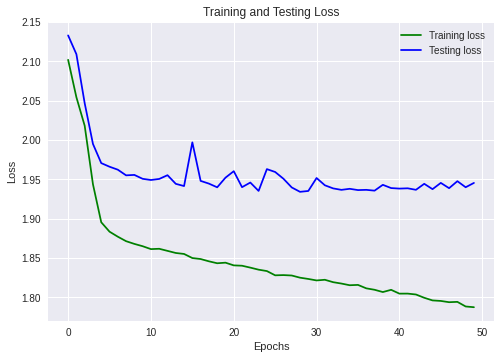

In [ ]:
pltloss(train_loss, test_loss, opts['epochs'])

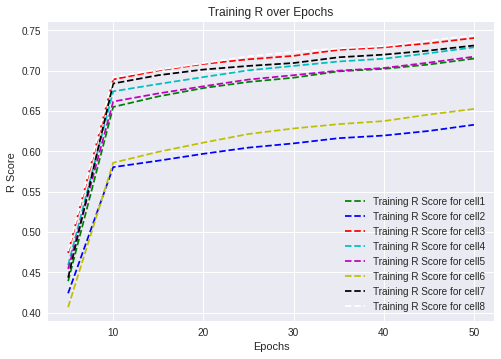

In [ ]:
pltR_train(r_list_tr, opts['epochs'])

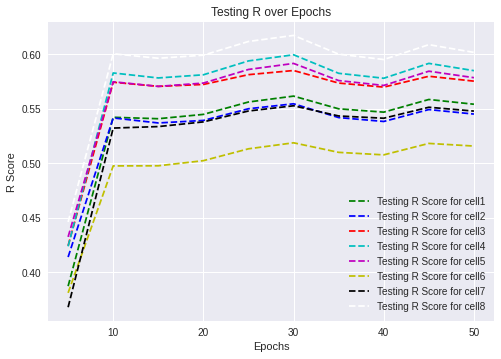

In [ ]:
pltR_test(r_list_ts, opts['epochs'])

### VGG

In [ ]:
class VGG16(nn.Module):
    def __init__(self, input_size):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv1d(input_size[0], 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv1d(128, 128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv1d(256, 256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv1d(512, 512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv1d(512, 512, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        # max pooling (kernel_size, stride)
        self.pool = nn.MaxPool1d(2, 2)

        # fully conected layers
        self.fc6 = nn.Linear(512*18, 1000)
        # self.fc6 = nn.Linear(512*7, 1000)
        self.fc7 = nn.Linear(1000, 100)
        self.fc8 = nn.Linear(100, 1)
        self.log = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1_1(x)
        x = self.relu(x)
        x = self.conv1_2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2_1(x)
        x = self.relu(x)
        x = self.conv2_2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3_1(x)
        x = self.relu(x)
        x = self.conv3_2(x)
        x = self.relu(x)
        x = self.conv3_3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv4_1(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.relu(x)
        x = self.conv4_3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.relu(self.conv5_1(x))
        x = self.relu(self.conv5_2(x))
        x = self.relu(self.conv5_3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        
        output = []
        for i in range(types):
          tmp = self.fc6(x)
          tmp = self.relu(tmp)
          tmp = self.dropout(tmp)
          
          tmp = self.fc7(tmp)
          tmp = self.relu(tmp)
          tmp = self.dropout(tmp)
          tmp = self.fc8(tmp)

          output.append(tmp)

        return output

In [ ]:
vgg = VGG16(train_X.shape[1:])
vgg

VGG16(
  (conv1_1): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2_1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3_1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3_2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3_3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4_1): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4_2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4_3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5_1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5_2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5_3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (drop

In [ ]:
opts = {
    'lr': 5e-5,
    'epochs': 50,
    'batch_size': 100,
    'loss_fxn': 'mse',
    'opt': 'Adam'
}

In [ ]:
test_loss, train_loss = [], []
VGGTrainer = TrainHelper(model = vgg,
                      train_set = train_dataset,
                      test_set = valid_dataset, opts = opts)

In [ ]:
VGGTrainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch: 1, train loss: 6.754301376889149, test loss: 6.333853977918625



epoch: 2, train loss: 5.637027444690466, test loss: 5.837031199038028



epoch: 3, train loss: 5.513872580478589, test loss: 6.709076927229762



epoch: 4, train loss: 5.362849067524076, test loss: 5.7723826609551905



epoch: 5, train loss: 5.263536420216163, test loss: 5.935612013190985



epoch: 6, train loss: 5.162598119924466, test loss: 5.516109638661146



epoch: 7, train loss: 5.157011463244756, test loss: 5.454179000854492



epoch: 8, train loss: 5.195404537767172, test loss: 5.437200368195772



epoch: 9, train loss: 5.061550565312306, test loss: 5.5210519261658195



epoch: 10, train loss: 5.0369110574324925, test loss: 6.009018620848655



epoch: 11, train loss: 5.00674894079566, test loss: 5.571034253388643



epoch: 12, train loss: 4.915185792744159, test loss: 5.435221330076456



epoch: 13, train loss: 4.960505765428146, test loss: 5.453343069553375



epoch: 14, train loss: 4.882019668072462, test loss: 5.641352871060372



epoch: 15, train loss: 4.939098348716895, test loss: 5.593780273944139



epoch: 16, train loss: 4.847418665637573, test loss: 5.678554844111204



epoch: 17, train loss: 4.751045543203751, test loss: 5.855639772862196



epoch: 18, train loss: 4.7603691803912325, test loss: 5.848373222351074



epoch: 19, train loss: 4.6068930151561895, test loss: 5.572893818095326



epoch: 20, train loss: 4.533118283127745, test loss: 5.674206663668156



epoch: 21, train loss: 4.445679889122645, test loss: 5.670594464242458



epoch: 22, train loss: 4.202059533447027, test loss: 5.805289972573519



epoch: 23, train loss: 4.032955926656723, test loss: 5.8327404230833055



epoch: 24, train loss: 3.8724049096306166, test loss: 5.899047130346299



epoch: 25, train loss: 3.7291072383522987, test loss: 5.982063091546297



epoch: 26, train loss: 3.548132437467575, test loss: 6.155308001488447



epoch: 27, train loss: 3.4782476385434467, test loss: 6.172936405241489



epoch: 28, train loss: 3.2713668902715045, test loss: 6.208097326010465



epoch: 29, train loss: 3.1639334626495836, test loss: 6.16169731542468



epoch: 30, train loss: 3.082283773024877, test loss: 6.476834218204021



epoch: 31, train loss: 3.0735124525924524, test loss: 6.285406555980444



epoch: 32, train loss: 2.893324684724212, test loss: 6.2792454153299335



epoch: 33, train loss: 2.829675384859244, test loss: 6.187042151391506



epoch: 34, train loss: 2.851022478938103, test loss: 6.187859231233597



epoch: 35, train loss: 2.8167263892789682, test loss: 6.247134307771921



epoch: 36, train loss: 2.73631852666537, test loss: 6.368922704458237



epoch: 37, train loss: 2.6605530135333537, test loss: 6.294818542152643



epoch: 38, train loss: 2.637346903110544, test loss: 6.303158013522625



epoch: 39, train loss: 2.573177306726575, test loss: 6.226290317624807



epoch: 40, train loss: 2.554814814031124, test loss: 6.208248852938413



epoch: 41, train loss: 2.5193760228653748, test loss: 6.233521242439747



epoch: 42, train loss: 2.50643320530653, test loss: 6.4448924161493775



epoch: 43, train loss: 2.4419249647607404, test loss: 6.31028538942337



epoch: 44, train loss: 2.420802553743124, test loss: 6.418058866262436



epoch: 45, train loss: 2.4064118176698686, test loss: 6.195585047453642



epoch: 46, train loss: 2.3656572819997868, test loss: 6.262297064065933



epoch: 47, train loss: 2.316631055995822, test loss: 6.302225647121668



epoch: 48, train loss: 2.3148482429484525, test loss: 6.509068443626165



epoch: 49, train loss: 2.287400980045398, test loss: 6.549330548942089



epoch: 50, train loss: 2.260489117478331, test loss: 6.285826637595892


#### Check for Output

In [ ]:
r_list_ts = []
r_list_tr = []
for num in range(opts['epochs']//5):
  vgg.load_state_dict(torch.load('model/model'+save_model_time+'/net_params_'+str(num)+'.pkl'))
  vgg.cuda()
  tr, ts = getR(vgg)
  r_list_ts.append(ts)
  r_list_tr.append(tr)

In [ ]:
max(r_list_ts)

[0.5639177177253617,
 0.5630889716058232,
 0.5896473885458515,
 0.6207199406066881,
 0.6090349371177908,
 0.5181045746995812,
 0.5465613150986638,
 0.6378434847302418]

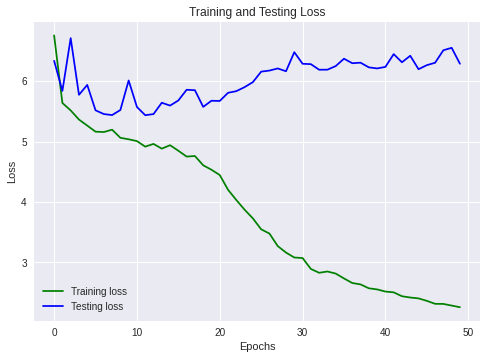

In [ ]:
pltloss(train_loss, test_loss, opts['epochs'])

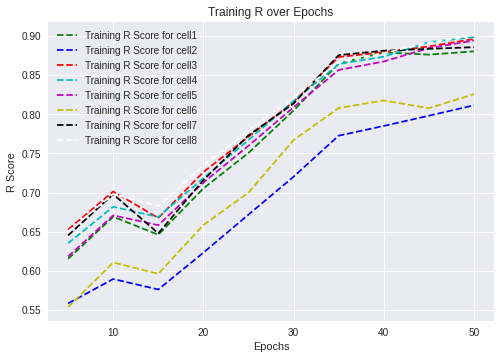

In [ ]:
pltR_train(r_list_tr, opts['epochs'])

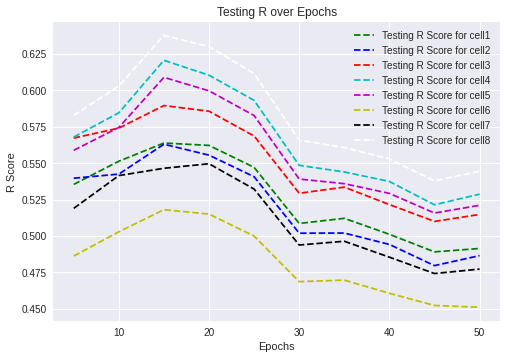

In [ ]:
pltR_test(r_list_ts, opts['epochs'])